In [36]:
from google.colab import drive
import pandas as pd


drive.mount('/content/drive')


file_path = '/content/drive/MyDrive/dataset/IoT/telemetry_data.csv'
df = pd.read_csv(file_path)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


## Data Pre-processing

In [37]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

In [38]:
def parse(x):
    return pd.to_datetime(x, infer_datetime_format=True, unit='s',utc=True)


In [39]:
df = pd.read_csv(file_path,
                  delimiter=',',
                  header=0,
                  infer_datetime_format=True,
                  date_parser=parse,
                  index_col=['ts'])


<ipython-input-39-fabfa77d433d>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path,
<ipython-input-39-fabfa77d433d>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(file_path,
<ipython-input-38-643346f0792d>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(x, infer_datetime_format=True, unit='s',utc=True)
<ipython-input-38-643346f0792d>:2:

In [40]:
# sort data
df = df.sort_values(by='ts', ascending=True)


In [41]:
# convert celsius to fahrenheit (°C to °F)
df['temp'] = (df['temp'] * 1.8) + 32


In [42]:
# preview data
df.head(5)


,device,co,humidity,light,lpg,motion,smoke,temp
ts,,,,,,,,
2020-07-12 00:01:34.385974646+00:00,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000
2020-07-12 00:01:34.735567570+00:00,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001
2020-07-12 00:01:38.073572874+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000
2020-07-12 00:01:39.589145899+00:00,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000
2020-07-12 00:01:41.761234999+00:00,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000


#### Outlier handeling

In [43]:
# filter temp/humidity, by device, for outliers (>1% & <99%)
df = df.loc[df['temp'] >df.groupby('device').temp.transform(lambda x: x.quantile(.01))]
df = df.loc[df['temp'] < df.groupby('device').temp.transform(lambda x: x.quantile(.99))]

df = df.loc[df['humidity'] > df.groupby('device').humidity.transform(lambda x: x.quantile(.01))]
df = df.loc[df['humidity'] < df.groupby('device').humidity.transform(lambda x: x.quantile(.99))]


In [44]:
# group data by iot device
groups = df.groupby('device')


In [45]:
print('DataFrame Stats')
print('-------------')
print('Record count: {:,}'.format(df['temp'].count()))
print('DataFrame size (MB): {:,.2f}'.format(sys.getsizeof(df)/1024/1024))
print('-------------')
print('Time range (min): {:%Y-%m-%d %H:%M:%S %Z}'.format(df.index[1]))
print('Time range (max): {:%Y-%m-%d %H:%M:%S %Z}'.format(df.index[-1]))
print('Temperature (min): {:.2f}'.format(df['temp'].min()))
print('Temperature (max): {:.2f}'.format(df['temp'].max()))
print('Humidity (min): {:.2f}{}'.format(df['humidity'].min(), '%'))
print('Humidity (max): {:.2f}{}'.format(df['humidity'].max(), '%'))
print('-------------')
print('Record count:\n{}'.format(groups.size()))


DataFrame Stats
-------------
Record count: 385,464
DataFrame size (MB): 45.58
-------------
Time range (min): 2020-07-12 00:01:34 UTC
Time range (max): 2020-07-20 00:03:37 UTC
Temperature (min): 65.66
Temperature (max): 86.36
Humidity (min): 46.60%
Humidity (max): 90.70%
-------------
Record count:
device
00:0f:00:70:91:0a    106187
1c:bf:ce:15:ec:4d    101056
b8:27:eb:bf:9d:51    178221
dtype: int64


#### Temperature Graph

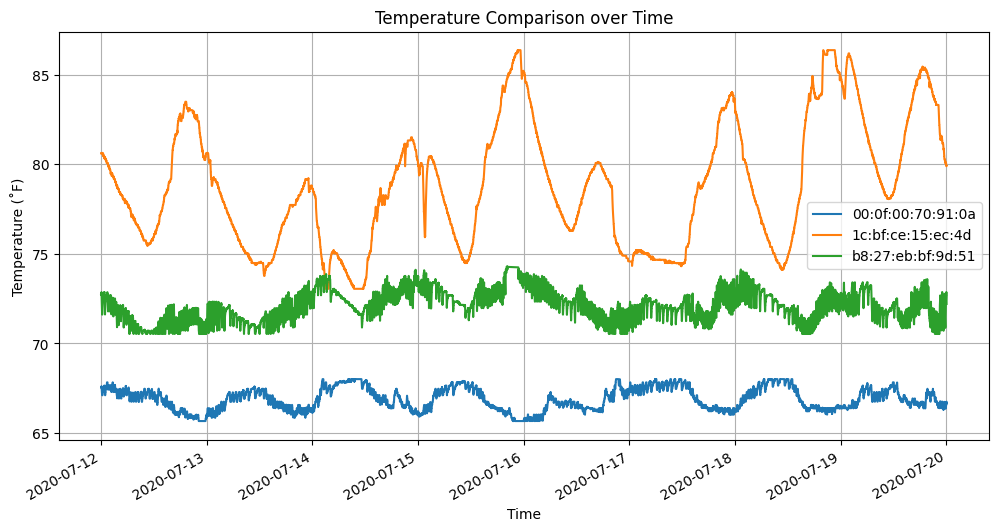

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for device, group in groups:
    group.mean = group.temp.rolling(window=20).mean()
    ax.plot(group.mean,
            label=device)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature Comparison over Time')
plt.ylabel('Temperature (˚F)')
plt.xlabel('Time')
plt.show()


#### Temperature Graph

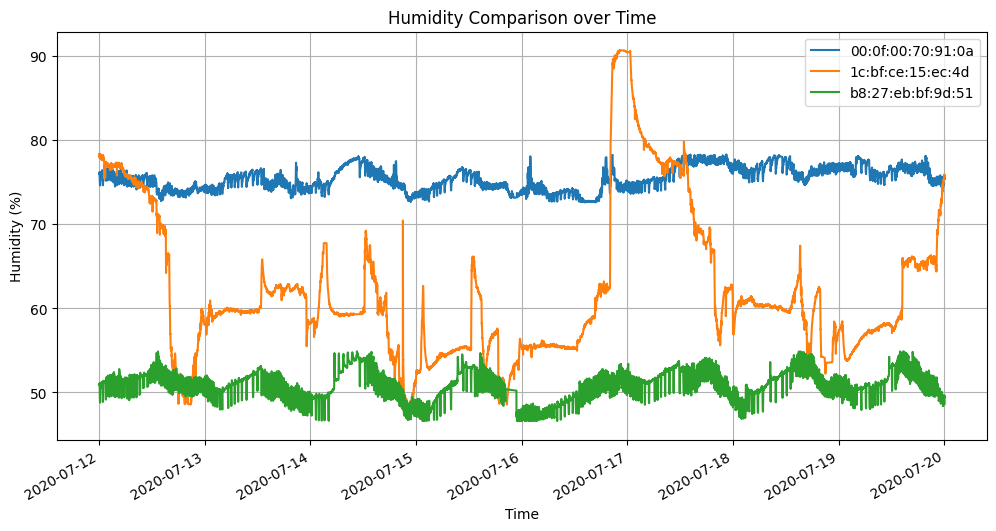

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for device, group in groups:
    group.mean = group.humidity.rolling(window=20).mean()
    ax.plot(group.mean,
            label=device)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Humidity Comparison over Time')
plt.ylabel('Humidity (%)')
plt.xlabel('Time')
plt.show()


## Univariate Analysis

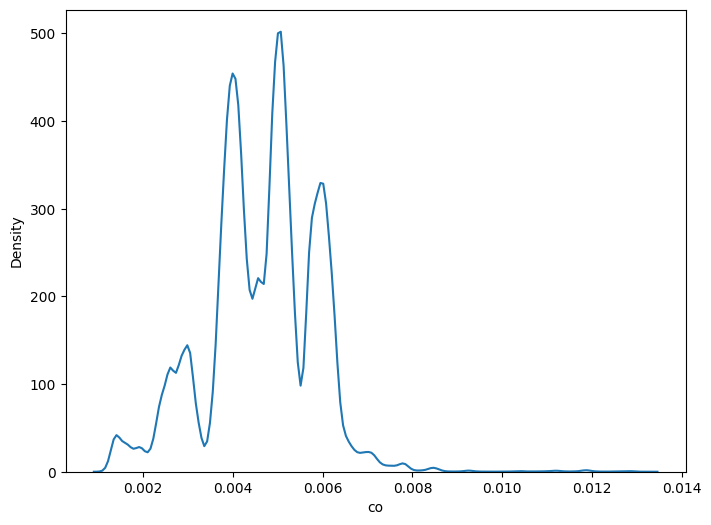

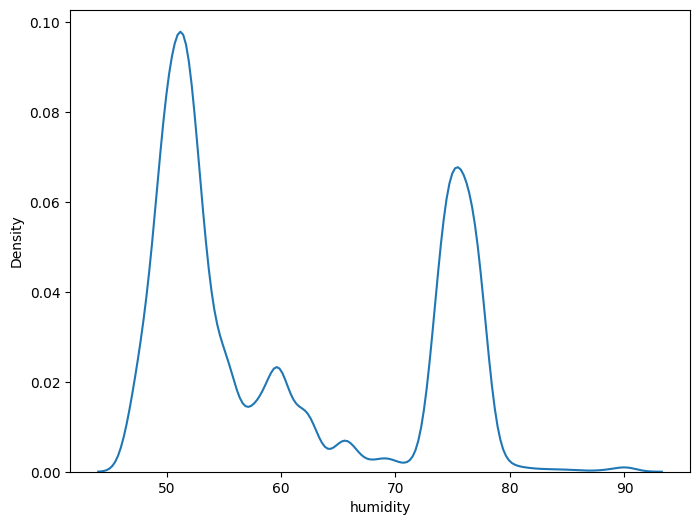

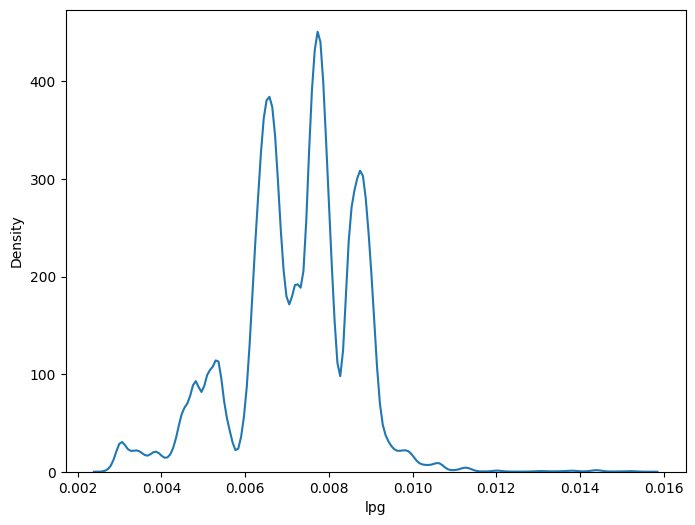

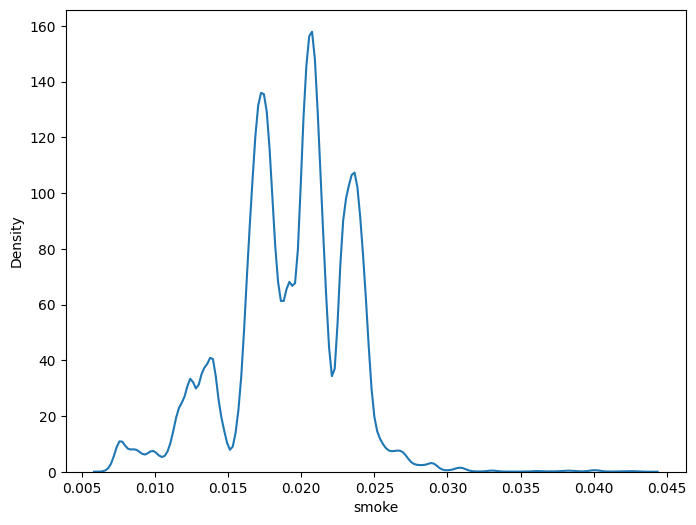

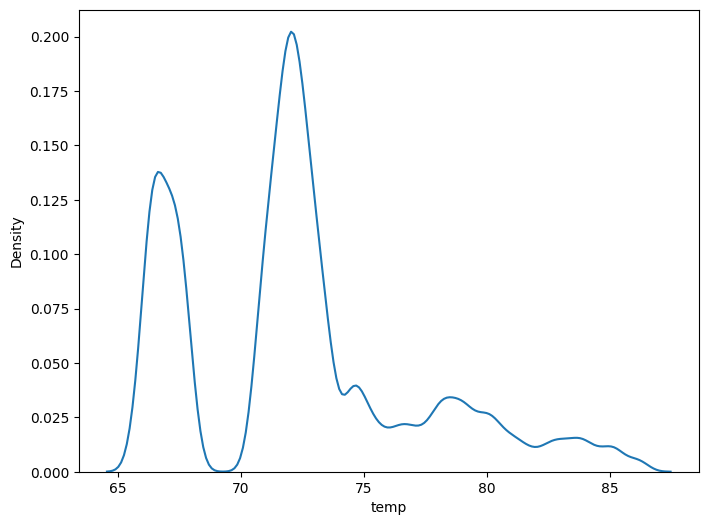

In [48]:
for i in df.columns:
    if df[i].nunique() > 5:
        plt.figure(figsize=(8, 6))
        sns.kdeplot(x=i, data=df)
        plt.show()


#### Multivariate Analysis

In [49]:
from sklearn.preprocessing import LabelEncoder

encLab = LabelEncoder()
deviceEnc = pd.DataFrame(encLab.fit_transform(df['device']), columns=['condition'])
deviceEnc.index = df.index

dataEnc = pd.concat([df, deviceEnc], axis=1)
dataEnc.head()

,device,co,humidity,light,lpg,motion,smoke,temp,condition
ts,,,,,,,,,
2020-07-12 00:01:34.385974646+00:00,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000,2
2020-07-12 00:01:34.735567570+00:00,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001,0
2020-07-12 00:01:38.073572874+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000,2
2020-07-12 00:01:39.589145899+00:00,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000,1
2020-07-12 00:01:41.761234999+00:00,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000,2


In [50]:
encLab2 = LabelEncoder()
lightEnc = pd.DataFrame(encLab2.fit_transform(dataEnc['light']), columns=['lights'])
lightEnc.index = dataEnc.index

dataEnc2 = pd.concat([dataEnc, lightEnc], axis=1)
dataEnc2.head()


,device,co,humidity,light,lpg,motion,smoke,temp,condition,lights
ts,,,,,,,,,,
2020-07-12 00:01:34.385974646+00:00,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000,2,0
2020-07-12 00:01:34.735567570+00:00,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001,0,0
2020-07-12 00:01:38.073572874+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000,2,0
2020-07-12 00:01:39.589145899+00:00,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000,1,1
2020-07-12 00:01:41.761234999+00:00,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000,2,0


In [51]:
df = dataEnc2.drop(['device', 'light'], axis=1)
df.head()


,co,humidity,lpg,motion,smoke,temp,condition,lights
ts,,,,,,,,
2020-07-12 00:01:34.385974646+00:00,0.004956,51.000000,0.007651,False,0.020411,72.860000,2,0
2020-07-12 00:01:34.735567570+00:00,0.002840,76.000000,0.005114,False,0.013275,67.460001,0,0
2020-07-12 00:01:38.073572874+00:00,0.004976,50.900000,0.007673,False,0.020475,72.680000,2,0
2020-07-12 00:01:39.589145899+00:00,0.004403,76.800003,0.007023,False,0.018628,80.600000,1,1
2020-07-12 00:01:41.761234999+00:00,0.004967,50.900000,0.007664,False,0.020448,72.680000,2,0


In [52]:
def barplot(columnname):
    val = df[columnname]
    valCount = val.value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(valCount.index, valCount)
    plt.title(columnname)
    plt.ylabel('Frequency')
    plt.show()


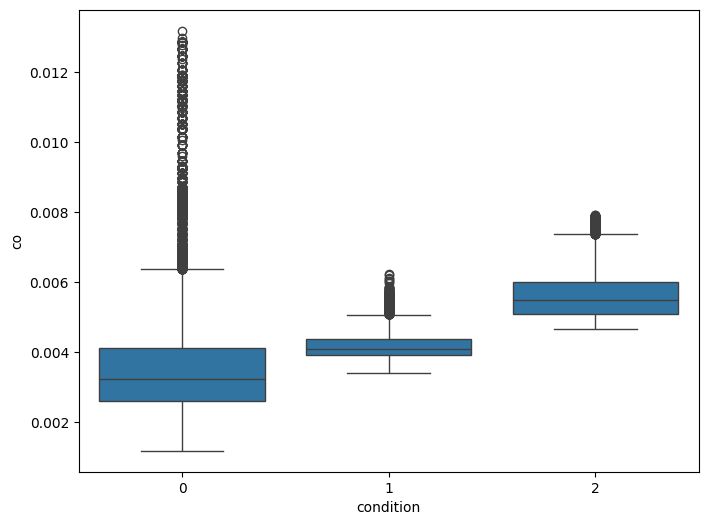

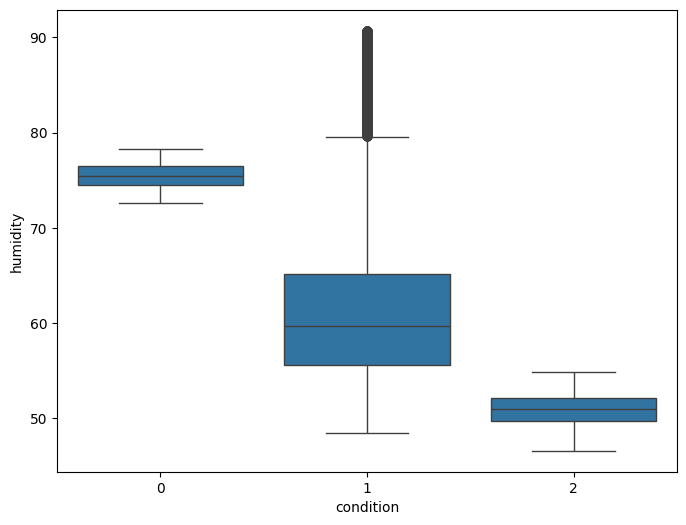

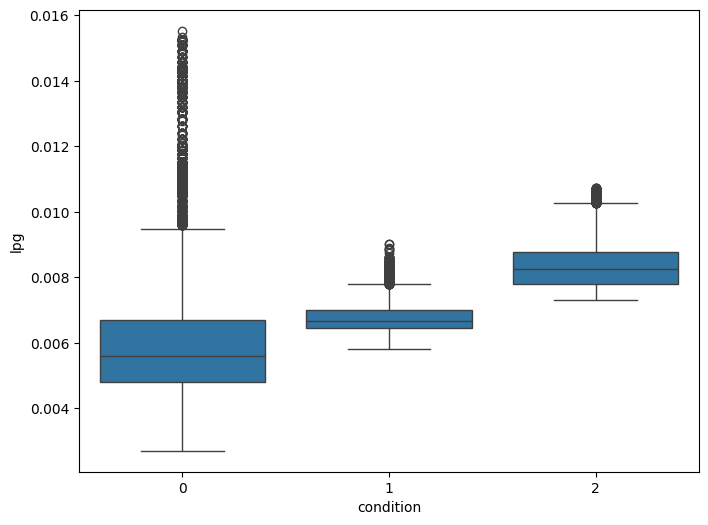

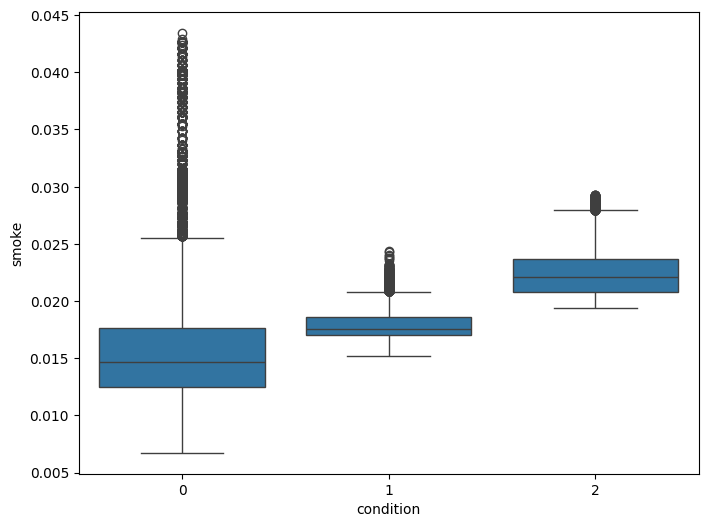

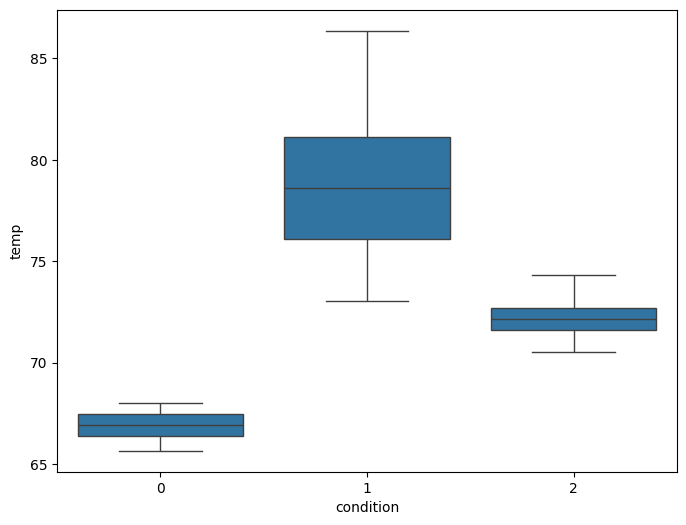

In [53]:
for k in df.columns:
    if df[k].nunique() > 5:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df['condition'], y=df[k])
        plt.show()

